In [1]:
import xarray as xr
import numpy as np 
import dask
import matplotlib.pyplot as pl
import datetime as dt
from dateutil.relativedelta import relativedelta
import pandas as pd
from netCDF4 import Dataset
import gsw
pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
#Write down the units

import json

units = {'nh4': 'mmol/m3',
         'no3': 'mmol/m3',
         'no2': 'mmol/m3',
         'po4': 'mmol/m3',
         'o2': 'mmol/m3',
         'h2s': 'mmol/m3',
         'temp': 'deg.C',
         'salt': 'g/kg',
         'Chlorophyll A': 'mg/m3',
         'depth': 'm',
         'lon': 'deg.E',
         'lat': 'deg.N'}

# Serialize data into file:
#json.dump(units, open( "/silod4/naumov/obs_datasets_handler/datasets/units.json", 'w' ))

In [47]:
#Preprocessing raw data from all sources (needs to be done anyway to avoid loading huge raw datasets every time and processing them the same way)
#iow
#Open everything
dateparse = lambda a,b,c: dt.datetime.strptime(str(a)+str(b)+str(c), '%Y%m%d')

iow_salt1 = pd.read_csv('/silod4/naumov/obs_datasets_handler/datasets/iow/iow_salinity_1.csv', 
                      skiprows = [1,2], 
                      encoding = 'unicode_escape',
                      skipfooter=5, 
                      engine='python',
                      parse_dates={'date': [1,2,3]},
                      date_parser=dateparse).drop(columns=['Station name', 'Hour', 'Minute', 
                                                           'Second', 'Longitude.1', 'Longitude.2', 
                                                           'Latitude.1', 'Latitude.2'])

iow_salt2 = pd.read_csv('/silod4/naumov/obs_datasets_handler/datasets/iow/iow_salinity_2.csv', 
                      skiprows = [1,2], 
                      encoding = 'unicode_escape',
                      skipfooter=5, 
                      engine='python',
                      parse_dates={'date': [1,2,3]}, 
                      date_parser=dateparse).drop(columns=['Station name', 'Hour', 'Minute', 
                                                           'Second', 'Longitude.1', 'Longitude.2', 
                                                           'Latitude.1', 'Latitude.2'])

iow_temp1 = pd.read_csv('/silod4/naumov/obs_datasets_handler/datasets/iow/iow_temperature_1.csv', 
                      skiprows = [1,2], 
                      encoding = 'unicode_escape',
                      skipfooter=5, 
                      engine='python',
                      parse_dates={'date': [1,2,3]}, 
                      date_parser=dateparse).drop(columns=['Station name', 'Hour', 'Minute', 
                                                           'Second', 'Longitude.1', 'Longitude.2', 
                                                           'Latitude.1', 'Latitude.2'])

iow_temp2 = pd.read_csv('/silod4/naumov/obs_datasets_handler/datasets/iow/iow_temperature_2.csv', 
                      skiprows = [1,2], 
                      encoding = 'unicode_escape',
                      skipfooter=5, 
                      engine='python',
                      parse_dates={'date': [1,2,3]}, 
                      date_parser=dateparse).drop(columns=['Station name', 'Hour', 'Minute', 
                                                           'Second', 'Longitude.1', 'Longitude.2', 
                                                           'Latitude.1', 'Latitude.2'])

iow_temp3 = pd.read_csv('/silod4/naumov/obs_datasets_handler/datasets/iow/iow_temperature_3.csv', 
                      skiprows = [1,2], 
                      encoding = 'unicode_escape',
                      skipfooter=5, 
                      engine='python',
                      parse_dates={'date': [1,2,3]}, 
                      date_parser=dateparse).drop(columns=['Station name', 'Hour', 'Minute', 
                                                           'Second', 'Longitude.1', 'Longitude.2', 
                                                           'Latitude.1', 'Latitude.2'])


iow_bio = pd.read_csv('/silod4/naumov/obs_datasets_handler/datasets/iow/iow_bio_1.csv', 
                      skiprows = [1,2], 
                      encoding = 'unicode_escape',
                      skipfooter=5, 
                      engine='python',
                      parse_dates={'date': [1,2,3]}, 
                      date_parser=dateparse).drop(columns=['Station name', 'Hour', 'Minute', 
                                                           'Second', 'Longitude.1', 'Longitude.2', 
                                                           'Latitude.1', 'Latitude.2'])

iow_bio_cl = pd.read_csv('/silod4/naumov/obs_datasets_handler/datasets/iow/iow_bio_cl.csv', 
                      skiprows = [1,2], 
                      encoding = 'unicode_escape',
                      skipfooter=5, 
                      engine='python',
                      parse_dates={'date': [1,2,3]}, 
                      date_parser=dateparse).drop(columns=['Station name', 'Hour', 'Minute', 
                                                           'Second', 'Longitude.1', 'Longitude.2', 
                                                           'Latitude.1', 'Latitude.2', '1966)'])

In [170]:
chl_std = np.nanstd(iow_bio_cl['Chlorophyll A (UNESCO'])
iow_bio_cl.loc[iow_bio_cl['Chlorophyll A (UNESCO'] >= 2*chl_std, 'Chlorophyll A (UNESCO'] = np.nan

In [49]:
iow_temp1['depth'] = np.abs(gsw.z_from_p(iow_temp1.Pressure, iow_temp1.Latitude))
iow_temp1['temp1'] = np.nanmean([iow_temp1.Temperature, iow_temp1['Temperature.1']], axis = 0)
iow_temp1.drop(columns=['Pressure', 'Temperature', 'Temperature.1'], inplace= True)

iow_temp2['depth'] = np.abs(gsw.z_from_p(iow_temp2.Pressure, iow_temp2.Latitude))
iow_temp2['temp2'] = np.nanmean([iow_temp2.Temperature, iow_temp2['Temperature.1'], iow_temp2['Temperature.2'], iow_temp2['Temperature.3']], axis = 0)
iow_temp2.drop(columns=['Pressure', 'Temperature', 'Temperature.1', 'Temperature.2', 'Temperature.3'], inplace= True)

iow_temp3['depth'] = np.abs(gsw.z_from_p(iow_temp3.Pressure, iow_temp3.Latitude))
iow_temp3.rename(columns={'Temperature':'temp3'}, inplace=True)

iow_temp = pd.concat([iow_temp1, iow_temp2, iow_temp3], ignore_index=True)

In [53]:
iow_temp['temp'] = np.nanmean([iow_temp.temp1, iow_temp.temp2, iow_temp.temp3], axis = 0)
iow_temp.drop(columns=['Pressure', 'temp1', 'temp2', 'temp3'], inplace=True)

In [57]:
iow_temp = iow_temp.groupby(['date', 'Longitude', 'Latitude', 'depth']).agg('mean').reset_index()

In [59]:
iow_salt1['depth'] = np.abs(gsw.z_from_p(iow_salt1.Pressure, iow_salt1.Latitude))
iow_salt1['salt1'] = np.nanmean([iow_salt1.Salinity, iow_salt1['Salinity.1'], iow_salt1['Salinity.2'], iow_salt1['Salinity.3'], iow_salt1['Salinity.4']], axis = 0)
iow_salt1.drop(columns=['Pressure', 'Salinity', 'Salinity.1', 'Salinity.2', 'Salinity.3', 'Salinity.4'], inplace= True)

iow_salt2['depth'] = np.abs(gsw.z_from_p(iow_salt2.Pressure, iow_salt2.Latitude))
iow_salt2['salt2'] = np.nanmean([iow_salt2.Salinity, 
                                 iow_salt2['Salinity.1'], 
                                 iow_salt2['Salinity.2'], 
                                 iow_salt2['Salinity.3'], 
                                 iow_salt2['Salinity.4'], 
                                 iow_salt2['Salinity.5']], axis = 0)
iow_salt2.drop(columns=['Pressure', 'Salinity', 'Salinity.1', 'Salinity.2', 'Salinity.3', 'Salinity.4', 'Salinity.5'], inplace= True)

iow_salt = pd.concat([iow_salt1, iow_salt2], ignore_index=True)

In [63]:
iow_salt['salt'] = np.nanmean([iow_salt.salt1, iow_salt.salt2], axis = 0)
iow_salt.drop(columns=['salt1', 'salt2'], inplace=True)

In [71]:
iow_salt = iow_salt.groupby(['date', 'Longitude', 'Latitude', 'depth']).agg('mean').reset_index()

In [75]:
iow_phy = pd.merge(iow_temp, iow_salt, 
                   on=['date', 'Longitude', 'Latitude', 'depth'], 
                   how='outer', 
                   indicator=True)

In [81]:
iow_phy.drop(columns='_merge', inplace=True)
iow_phy = iow_phy.groupby(['date', 'Longitude', 'Latitude', 'depth']).agg('mean').reset_index()

In [171]:
iow_bio['depth'] = np.abs(gsw.z_from_p(iow_bio.Pressure, iow_bio.Latitude))
iow_bio['Oxygen'] = iow_bio['Oxygen'] * 44.661 # ml/l ---> mmol/m^3
iow_bio['Oxygen.1'] = iow_bio['Oxygen.1'] * 44.661 # ml/l ---> mmol/m^3
iow_bio['Oxygen.2'] = iow_bio['Oxygen.2'] * 44.661 # ml/l ---> mmol/m^3
iow_bio['Sauerstoff'] = iow_bio['Sauerstoff'] * 1.025 # micromoles/kg ---> mmol/m^3
iow_bio['h2s'] = np.nanmean([iow_bio['Schwefelwasserstoffgehalt'], iow_bio['Schwefelwasserstoffgehalt.1']], axis = 0)
iow_bio.loc[iow_bio['h2s'] > 3*np.nanstd(iow_bio['h2s']), 'h2s'] = np.nan

#Convert negative O2 to H2S
iow_bio.loc[(iow_bio['Oxygen'] < 0) & (np.isnan(iow_bio['h2s'])), 'h2s'] = -0.5 * iow_bio.loc[(iow_bio['Oxygen'] < 0) & (np.isnan(iow_bio['h2s'])), 'Oxygen']
iow_bio.loc[(iow_bio['Oxygen.2'] < 0) & (np.isnan(iow_bio['h2s'])), 'h2s'] = -0.5 * iow_bio.loc[(iow_bio['Oxygen.2'] < 0) & (np.isnan(iow_bio['h2s'])), 'Oxygen.2']
iow_bio.loc[(iow_bio['Sauerstoff'] < 0) & (np.isnan(iow_bio['h2s'])), 'h2s'] = -0.5 * iow_bio.loc[(iow_bio['Sauerstoff'] < 0) & (np.isnan(iow_bio['h2s'])), 'Sauerstoff']
iow_bio.loc[iow_bio['Oxygen'] < 0, 'Oxygen'] = 0.
iow_bio.loc[iow_bio['Oxygen.2'] < 0, 'Oxygen.2'] = 0.
iow_bio.loc[iow_bio['Sauerstoff'] < 0, 'Sauerstoff'] = 0.

#Average over different measurement devices
iow_bio['chl'] = np.nanmean([iow_bio['Chlorophyll A Jeffrey/Humphrey'], iow_bio['Chlorophyll A Lorenzen']], axis = 0)
iow_bio['o2'] = np.nanmean([iow_bio.Oxygen, iow_bio['Oxygen.1'], iow_bio['Oxygen.2'], iow_bio['Sauerstoff']], axis = 0)

#Drop useless columns
iow_bio.drop(columns=['Pressure', 
                      'Oxygen', 
                      'Oxygen.1', 
                      'Oxygen.2', 
                      'Sauerstoff',
                      'Schwefelwasserstoffgehalt.1',
                      'Schwefelwasserstoffgehalt',
                      'Chlorophyll A Jeffrey/Humphrey',
                      'Chlorophyll A Lorenzen'], inplace= True)

/silos/conda_packages/naumov/miniconda3_4.8.2/OS_42.3/conda_env/iow_python/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/silos/conda_packages/naumov/miniconda3_4.8.2/OS_42.3/conda_env/iow_python/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice
/silos/conda_packages/naumov/miniconda3_4.8.2/OS_42.3/conda_env/iow_python/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


In [175]:
iow_bio_cl['depth'] = np.abs(gsw.z_from_p(iow_bio_cl.Pressure, iow_bio_cl.Latitude))
iow_bio_cl.drop(columns='Pressure', inplace=True)

In [176]:
iow_bio = pd.merge(iow_bio, iow_bio_cl, 
                   on=['date', 'Longitude', 'Latitude', 'depth'], 
                   how='outer')

In [193]:
iow_bio['chl'] = np.nanmean([iow_bio['chl'], iow_bio['Chlorophyll A (UNESCO']], axis = 0)
iow_bio.drop(columns='Chlorophyll A (UNESCO', inplace=True)

/silos/conda_packages/naumov/miniconda3_4.8.2/OS_42.3/conda_env/iow_python/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [194]:
iow_bio = iow_bio.groupby(['date', 'Longitude', 'Latitude', 'depth']).agg('mean').reset_index()

In [197]:
iow_data = pd.merge(iow_bio, iow_phy, 
                   on=['date', 'Longitude', 'Latitude', 'depth'], 
                   how='outer',
                   indicator=True)

In [200]:
#Get the data sorted
iow_data = iow_data.groupby(['date', 'Longitude', 'Latitude', 'depth']).agg('mean').reset_index()

In [205]:
iow_data = iow_data.rename(columns={'Longitude': 'lon', 
                                    'Latitude': 'lat', 
                                    'Ammonium': 'nh4', 
                                    'Nitrate': 'no3', 
                                    'Nitrite': 'no2', 
                                    'Phosphate': 'po4'})
#Save the results
#iow_data.to_csv('/silod4/naumov/obs_datasets_handler/datasets/iow/iow_data.csv', index=False)

In [385]:
iow_data

date      lon      lat      depth  nh4  no3  no2  po4  h2s  chl  \
0       1947-05-01  11.2250  54.0167   0.594643  NaN  NaN  NaN  NaN  NaN  NaN   
1       1947-05-02  11.2250  54.0167   0.594643  NaN  NaN  NaN  NaN  NaN  NaN   
2       1947-05-03  11.2250  54.0167   0.594643  NaN  NaN  NaN  NaN  NaN  NaN   
3       1947-05-04  11.2250  54.0167   0.594643  NaN  NaN  NaN  NaN  NaN  NaN   
4       1947-05-05  11.2250  54.0167   0.594643  NaN  NaN  NaN  NaN  NaN  NaN   
...            ...      ...      ...        ...  ...  ...  ...  ...  ...  ...   
5766835 2023-02-25  13.8667  54.8833  32.700290  NaN  NaN  NaN  NaN  NaN  NaN   
5766836 2023-02-25  13.8667  54.8833  39.636042  NaN  NaN  NaN  NaN  NaN  NaN   
5766837 2023-02-25  13.8667  54.8833  42.608435  NaN  NaN  NaN  NaN  NaN  NaN   
5766838 2023-02-25  14.1600  54.0767   2.973180  NaN  NaN  NaN  NaN  NaN  NaN   
5766839 2023-02-25  14.1600  54.0767  11.892458  NaN  NaN  NaN  NaN  NaN  NaN   

         o2   temp    salt  
0       NaN  5.200     NaN  
1       NaN  5.250     NaN  
2       NaN  5.200     NaN  
3       NaN  5.100     NaN  
4       NaN  5.000     NaN  
...      ..    ...     ...  
5766835 NaN  4.254   9.678  
5766836 NaN  5.840  15.980  
5766837 NaN  5.558  16.285  
5766838 NaN  3.520   7.940  
5766839 NaN  3.530   7.950  

[5766840 rows x 13 columns]

In [224]:
#ices bottle data

dateparse = lambda a,b,c: dt.datetime.strptime(str(a)+str(b)+str(c), '%Y%m%d')

ices_bot = pd.read_csv('/silod4/naumov/obs_datasets_handler/datasets/ices/ices_lr_ctd_data.txt', 
              sep='\t', 
              low_memory=False,
              usecols=[3,4,5,8,9,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46],
              parse_dates={'date': [0,1,2]}, date_parser=dateparse)

ices_bot.rename(columns = {'Latitude [degrees_north]': 'lat', 
                              'Longitude [degrees_east]' : 'lon', 
                              'Depth [m]' : 'depth',
                              'Dissolved Oxygen [ml/l]' : 'o2_ml_l',
                              'Dissolved Oxygen [ml/kg]' : 'o2_ml_kg',
                              'Nitrate Nitrogen (NO3-N) [umol/l]' : 'no3',
                              'Ammonium Nitrogen (NH4-N) [umol/l]' : 'nh4',
                              'Hydrogen Sulphide (H2S-S) [umol/l]' : 'h2s',
                              'Bot. Depth [m]': 'bot_depth',
                              'Secchi Depth [m]:METAVAR:FLOAT': 'secchi_depth',
                              'Pressure [dbar]': 'pressure',
                              'Temperature [degC]': 'temp',
                              'Practical Salinity [dmnless]': 'salt',
                              'Phosphate Phosphorus (PO4-P) [umol/l]': 'po4',
                              'Total Phosphorus (P) [umol/l]': 'tot_p',
                              'Silicate Silicon (SiO4-Si) [umol/l]': 'so4',
                              'Nitrite Nitrogen (NO2-N) [umol/l]': 'no2',
                              'Total Nitrogen (N) [umol/l]': 'tot_n',
                              'Hydrogen Ion Concentration (pH) [pH]': 'ph',
                              'Alkalinity [mEq/l]': 'alk',
                              'Chlorophyll a [ug/l]': 'chl',
                          }, inplace = True)

In [225]:
#convert oxygen
ices_bot.o2_ml_l = ices_bot.o2_ml_l * 44.661 # ml/l ---> mmol/m^3
ices_bot.o2_ml_kg = ices_bot.o2_ml_kg * 1.025 * (1/0.022391) # ml/kg ---> mmol/m^3

#average
ices_bot['o2'] = np.nanmean([ices_bot.o2_ml_l, ices_bot.o2_ml_kg], axis = 0)
ices_bot.drop(columns=['o2_ml_l', 'o2_ml_kg'],inplace=True)

In [232]:
ices_bot = ices_bot.groupby(['date', 'lon', 'lat', 'depth']).agg('mean').reset_index()

In [238]:
ices_ctd = pd.read_csv(f'/silod4/naumov/obs_datasets_handler/datasets/ices/ices_hr_ctd_data.txt', 
                          sep='\t', 
                          low_memory=False,
                          usecols=[3,4,5,8,9]+[x for x in range(10,30,2)],
                          parse_dates={'date': [0,1,2]}, date_parser=dateparse)

ices_ctd.rename(columns = {'Latitude [degrees_north]': 'lat', 
                              'Longitude [degrees_east]' : 'lon', 
                              'Depth [m]' : 'depth',
                              'Dissolved Oxygen [ml/l]' : 'o2_ml_l',
                              'Dissolved Oxygen [ml/kg]' : 'o2_ml_kg',
                              'Bot. Depth [m]': 'bot_depth',
                              'Secchi Depth [m]:METAVAR:FLOAT': 'secchi_depth',
                              'Pressure [dbar]': 'pressure',
                              'Temperature [degC]': 'temp',
                              'Practical Salinity [dmnless]': 'salt',
                              'Hydrogen Ion Concentration (pH) [pH]': 'ph',
                              'Chlorophyll a [ug/l]': 'chl',
                          }, inplace = True)

In [241]:
#convert oxygen
ices_ctd.o2_ml_l = ices_ctd.o2_ml_l * 44.661 # ml/l ---> mmol/m^3
ices_ctd.o2_ml_kg = ices_ctd.o2_ml_kg * 1.025 * (1/0.022391) # ml/kg ---> mmol/m^3

#average
ices_ctd['o2'] = np.nanmean([ices_ctd.o2_ml_l, ices_ctd.o2_ml_kg], axis = 0)
ices_ctd.drop(columns=['o2_ml_l', 'o2_ml_kg'],inplace=True)

/silos/conda_packages/naumov/miniconda3_4.8.2/OS_42.3/conda_env/iow_python/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


In [243]:
ices_ctd = ices_ctd.groupby(['date', 'lon', 'lat', 'depth']).agg('mean').reset_index()

In [248]:
#pumping data

ices_pump = pd.read_csv(f'/silod4/naumov/obs_datasets_handler/datasets/ices/ices_pump_data.txt', 
                          sep='\t', 
                          low_memory=False,
                          usecols=[3,4,5,8,9]+[x for x in range(10,36,2)],
                          parse_dates={'date': [0,1,2]}, date_parser=dateparse)

ices_pump.rename(columns = {'Latitude [degrees_north]': 'lat', 
                              'Longitude [degrees_east]' : 'lon', 
                              'Depth [m]' : 'depth',
                              'Nitrate Nitrogen (NO3-N) [umol/l]' : 'no3',
                              'Ammonium Nitrogen (NH4-N) [umol/l]' : 'nh4',
                              'Bot. Depth [m]': 'bot_depth',
                              'Pressure [dbar]': 'pressure',
                              'Temperature [degC]': 'temp',
                              'Practical Salinity [dmnless]': 'salt',
                              'Phosphate Phosphorus (PO4-P) [umol/l]': 'po4',
                              'Total Phosphorus (P) [umol/l]': 'tot_p',
                              'Silicate Silicon (SiO4-Si) [umol/l]': 'so4',
                              'Nitrite Nitrogen (NO2-N) [umol/l]': 'no2',
                              'Total Nitrogen (N) [umol/l]': 'tot_n',
                              'Chlorophyll a [ug/l]': 'chl',
                          }, inplace = True)

In [250]:
ices_pump = ices_pump.groupby(['date', 'lon', 'lat', 'depth']).agg('mean').reset_index()

In [260]:
#surface data

ices_surf = pd.read_csv(f'/silod4/naumov/obs_datasets_handler/datasets/ices/ices_surf_data.txt', 
                          sep='\t',
                          usecols=[3,4,5,8,9]+[x for x in range(10,20,2)],
                          low_memory=False,
                          parse_dates={'date': [0,1,2]}, date_parser=dateparse)

ices_surf.rename(columns = {'Latitude [degrees_north]': 'lat', 
                              'Longitude [degrees_east]' : 'lon', 
                              'Depth [m]' : 'depth',
                              'Bot. Depth [m]': 'bot_depth',
                              'Pressure [dbar]': 'pressure',
                              'Temperature [degC]': 'temp',
                              'Practical Salinity [dmnless]': 'salt',
                          }, inplace = True)

In [261]:
ices_surf = ices_surf.groupby(['date', 'lon', 'lat', 'depth']).agg('mean').reset_index()

In [267]:
# Prepare all ices datasets to merging

for col in ices_bot.columns:
    if col not in ices_ctd.columns:
        ices_ctd[col] = np.nan
    if col not in ices_pump.columns:
        ices_pump[col] = np.nan
    if col not in ices_surf.columns:
        ices_surf[col] = np.nan
        
ices_ctd = ices_ctd[ices_bot.columns]
ices_pump = ices_pump[ices_bot.columns]
ices_surf = ices_surf[ices_bot.columns]

In [271]:
#Merge everything
ices_data = pd.concat([ices_bot, ices_ctd, ices_pump, ices_surf], axis = 0, ignore_index=True)
ices_data.set_index(pd.Index(np.arange(ices_data.shape[0])))
ices_data = ices_data.groupby(['date', 'lon', 'lat', 'depth']).agg('mean').reset_index()

In [274]:
#negative depths are set to zero
ices_data.loc[ices_data.depth < 0, 'depth'] = 0

In [384]:
ices_data

date      lon      lat  depth  bot_depth  secchi_depth  \
0       1877-07-22  19.3030  60.1367    0.0        NaN           NaN   
1       1877-07-22  19.3030  60.1367    5.0        NaN           NaN   
2       1877-07-22  19.3030  60.1367   10.0        NaN           NaN   
3       1877-07-22  19.3030  60.1367   15.0        NaN           NaN   
4       1877-07-22  19.3030  60.1367   20.0        NaN           NaN   
...            ...      ...      ...    ...        ...           ...   
8970912 2022-12-09  12.2912  56.8732    5.0       24.0           NaN   
8970913 2022-12-09  12.2912  56.8732   10.0       24.0           NaN   
8970914 2022-12-09  12.2912  56.8732   15.0       24.0           NaN   
8970915 2022-12-09  12.2912  56.8732   20.0       24.0           NaN   
8970916 2022-12-09  12.2912  56.8732   22.0       24.0           NaN   

         pressure   temp   salt   po4  tot_p   so4  no3   no2  nh4  tot_n  \
0             NaN  12.50   5.39   NaN    NaN   NaN  NaN   NaN  NaN    NaN   
1             NaN  11.80   5.39   NaN    NaN   NaN  NaN   NaN  NaN    NaN   
2             NaN   9.40   5.53   NaN    NaN   NaN  NaN   NaN  NaN    NaN   
3             NaN   3.40   5.89   NaN    NaN   NaN  NaN   NaN  NaN    NaN   
4             NaN   3.30   6.04   NaN    NaN   NaN  NaN   NaN  NaN    NaN   
...           ...    ...    ...   ...    ...   ...  ...   ...  ...    ...   
8970912       NaN   3.88  24.85  0.55   0.82  11.7  4.8  0.15  0.4   17.3   
8970913       NaN   3.89  24.85  0.55   0.84  11.8  4.8  0.15  0.2   17.6   
8970914       NaN   4.01  24.98  0.61   0.86  11.9  4.8  0.15  0.3   17.3   
8970915       NaN   4.30  25.84  0.60   0.85  11.4  4.9  0.15  0.2   16.5   
8970916       NaN   4.51  26.06  0.70   1.03  12.0  5.1  0.18  0.3   17.7   

         h2s  ph  alk  chl          o2  
0        NaN NaN  NaN  NaN         NaN  
1        NaN NaN  NaN  NaN         NaN  
2        NaN NaN  NaN  NaN         NaN  
3        NaN NaN  NaN  NaN         NaN  
4        NaN NaN  NaN  NaN         NaN  
...      ...  ..  ...  ...         ...  
8970912  NaN NaN  NaN  1.5  347.909190  
8970913  NaN NaN  NaN  1.4  348.132495  
8970914  NaN NaN  NaN  1.1  343.219785  
8970915  NaN NaN  NaN  0.9  335.627415  
8970916  NaN NaN  NaN  NaN  331.384620  

[8970917 rows x 21 columns]

In [277]:
#Save ices data to a file
#ices_data.to_csv('/silod4/naumov/obs_datasets_handler/datasets/ices/ices_data.csv', index=False)

In [358]:
#shark data

shark_data = pd.read_csv('/silod4/naumov/obs_datasets_handler/datasets/shark/shark_data.txt', 
            sep=';', error_bad_lines=False, low_memory=False,
            usecols=[13,20,21,32,36,37,39,41,43,45,51,53,55,57,63,65,67,69,71,73,77,79,81,85,87,89,91,93])

In [359]:
shark_data.rename(columns = {'Sampling date': 'date',
                              'Sample latitude (DD)': 'lat', 
                              'Sample longitude (DD)' : 'lon', 
                              'Secchi depth (m)': 'secchi_depth',
                              'Sampling depth (m)': 'depth',
                              'Pressure CTD (dbar)': 'pressure',
                              'Temperature bottle (C)' : 'temp_bot',
                              'Temperature CTD (C)' : 'temp_ctd',
                              'Salinity bottle (o/oo psu)': 'salt_bot',
                              'Salinity CTD (o/oo psu)': 'salt_ctd',
                              'Dissolved oxygen O2 bottle (ml/l)': 'o2_bot',
                              'Dissolved oxygen O2 CTD (ml/l)': 'o2_ctd',
                              'Hydrogen sulphide H2S (umol/l)': 'h2s',
                              'pH': 'ph',
                              'Alkalinity (mmol/kg)': 'alk_mmol_kg',
                              'Alkalinity_2 (mmol/l)': 'alk_mmol_l',
                              'Phosphate PO4-P (umol/l)': 'po4',
                              'Total phosphorus Tot-P (umol/l)': 'tot_p',
                              'Nitrite NO2-N (umol/l)': 'no2',
                              'Nitrate NO3-N (umol/l)': 'no3',
                              'Ammonium NH4-N (umol/l)': 'nh4',
                              'Total Nitrogen Tot-N (umol/l)': 'tot_n',
                              'Silicate SiO3-Si (umol/l)': 'so4',
                              'Chlorophyll-a bottle (ug/l)': 'chl',
                              'Dissolved organic carbon DOC (umol/l)': 'doc',
                              'Particulate organic carbon POC (umol/l)': 'poc',
                              'Total organic carbon TOC (mg/l)': 'toc',
                              'Particulate organic nitrogen PON (umol/l)': 'pon'
                              }, inplace = True)

In [360]:
#convert oxygen
shark_data.o2_bot = shark_data.o2_bot * 44.661 # ml/l ---> mmol/m^3
shark_data.o2_ctd = shark_data.o2_ctd * 44.661 # ml/l ---> mmol/m^3
#average
shark_data['o2'] = np.nanmean([shark_data.o2_bot, shark_data.o2_ctd], axis = 0)
shark_data.drop(columns=['o2_bot', 'o2_ctd'],inplace=True)

shark_data['temp'] = np.nanmean([shark_data.temp_bot, shark_data.temp_ctd], axis = 0)
shark_data.drop(columns=['temp_bot', 'temp_ctd'],inplace=True)

shark_data['salt'] = np.nanmean([shark_data.salt_bot, shark_data.salt_ctd], axis = 0)
shark_data.drop(columns=['salt_bot', 'salt_ctd'],inplace=True)

shark_data.alk_mmol_kg = shark_data.alk_mmol_kg * 1025 # mmol/kg ---> mmol/m^3
shark_data.alk_mmol_l = shark_data.alk_mmol_l * 1e3 # mmol/l ---> mmol/m^3

shark_data['alk'] = np.nanmean([shark_data.alk_mmol_kg, shark_data.alk_mmol_l], axis = 0)
shark_data.drop(columns=['alk_mmol_kg', 'alk_mmol_l'],inplace=True)

/silos/conda_packages/naumov/miniconda3_4.8.2/OS_42.3/conda_env/iow_python/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/silos/conda_packages/naumov/miniconda3_4.8.2/OS_42.3/conda_env/iow_python/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/silos/conda_packages/naumov/miniconda3_4.8.2/OS_42.3/conda_env/iow_python/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/silos/conda_packages/naumov/miniconda3_4.8.2/OS_42.3/conda_env/iow_python/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


In [361]:
def check_type(x):
    r = True
    try:
        np.float(x)
    except:
        r = False
    return r

shark_data['depth_is_float'] = shark_data.depth.apply(check_type)
shark_data['pressure_is_float'] = shark_data.pressure.apply(check_type)

In [362]:
#Remove weird depths and pressures
shark_data.drop(index=shark_data.loc[shark_data['depth_is_float'] == False].index, inplace=True)
shark_data.drop(columns=['depth_is_float', 'pressure_is_float'], inplace=True)
#Assign correct datatype
shark_data.depth = shark_data.depth.astype(np.float64)
shark_data.pressure = shark_data.pressure.astype(np.float64)

In [365]:
#Remove weird dates
shark_data['date_type'] = shark_data.date.apply(lambda x: type(x) == str)
shark_data.drop(index=shark_data.loc[shark_data.date_type == 0].index, inplace=True)
shark_data.drop(columns=['date_type'], inplace=True)

In [368]:
#convert date to datetime format
shark_data.date = shark_data.date.apply(lambda x: x if len(x) == 10 else x+'-01')
shark_data.date = shark_data.date.apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [371]:
shark_data = shark_data.groupby(['date', 'lon', 'lat', 'depth']).agg('mean').reset_index()

In [383]:
shark_data

date       lon       lat  depth  secchi_depth  pressure  h2s  \
0       1893-05-17  11.54333  58.32000    0.0           NaN       NaN  NaN   
1       1893-05-17  11.54333  58.32000   10.0           NaN       NaN  NaN   
2       1893-05-17  11.54333  58.32000   20.0           NaN       NaN  NaN   
3       1893-05-17  11.54333  58.32000   30.0           NaN       NaN  NaN   
4       1893-05-17  11.54333  58.32000   40.0           NaN       NaN  NaN   
...            ...       ...       ...    ...           ...       ...  ...   
1027814 2023-02-16  16.53600  56.11632   15.0           NaN       NaN  NaN   
1027815 2023-02-16  16.53600  56.11632   20.0           NaN       NaN  NaN   
1027816 2023-02-16  16.53600  56.11632   30.0           NaN       NaN  NaN   
1027817 2023-02-16  16.53600  56.11632   40.0           NaN       NaN  NaN   
1027818 2023-02-16  16.53600  56.11632   49.0           NaN       NaN  NaN   

           ph   po4  tot_p   no2   no3  nh4  tot_n   so4  chl  doc  poc  toc  \
0         NaN   NaN    NaN   NaN   NaN  NaN    NaN   NaN  NaN  NaN  NaN  NaN   
1         NaN   NaN    NaN   NaN   NaN  NaN    NaN   NaN  NaN  NaN  NaN  NaN   
2         NaN   NaN    NaN   NaN   NaN  NaN    NaN   NaN  NaN  NaN  NaN  NaN   
3         NaN   NaN    NaN   NaN   NaN  NaN    NaN   NaN  NaN  NaN  NaN  NaN   
4         NaN   NaN    NaN   NaN   NaN  NaN    NaN   NaN  NaN  NaN  NaN  NaN   
...       ...   ...    ...   ...   ...  ...    ...   ...  ...  ...  ...  ...   
1027814  7.96  0.89    NaN  0.14  3.72  0.2    NaN  18.2  0.2  NaN  NaN  NaN   
1027815  7.96  0.89    NaN  0.14  3.77  0.2    NaN  21.2  0.2  NaN  NaN  NaN   
1027816  7.94  0.92    NaN  0.14  3.82  0.2    NaN  18.7  0.2  NaN  NaN  NaN   
1027817  7.90  0.94    NaN  0.05  3.80  0.2    NaN  19.0  0.2  NaN  NaN  NaN   
1027818  7.50  1.62    NaN  0.02  5.01  0.2    NaN  31.4  NaN  NaN  NaN  NaN   

         pon          o2   temp   salt  alk  
0        NaN         NaN  8.140  24.53  NaN  
1        NaN         NaN  7.000  28.95  NaN  
2        NaN         NaN  4.400  32.60  NaN  
3        NaN         NaN  4.030  33.44  NaN  
4        NaN         NaN  3.600  33.83  NaN  
...      ...         ...    ...    ...  ...  
1027814  NaN  366.220200  4.050   7.52  NaN  
1027815  NaN  370.686300  4.050   7.55  NaN  
1027816  NaN  366.220200  4.000   7.56  NaN  
1027817  NaN  347.909190  4.315   7.61  NaN  
1027818  NaN  209.236785  4.865   8.00  NaN  

[1027819 rows x 24 columns]

In [374]:
# #save shark data
# shark_data.to_csv('/silod4/naumov/obs_datasets_handler/datasets/shark/shark_data.csv', index=False)

In [3]:
import sys
import numpy as np 
import datetime as dt
from dateutil.relativedelta import relativedelta
import pandas as pd
import warnings

class obs_data_preprocessor:
    """
    This script merges four observational databases: IOW database, ICES database, SHARK database, and Validator database.
    
    The usage consists from the following steps:
    1. Define the object of the data processor with the following agruments:
    time_range - list consisted of the two datetime objects wich indicate the timespan for observational data [first_date, last_date]
    datasets - list of the datasets that will be used ['iow' or 'ices' or 'shark' or 'validator' or any combination of those]
    
    2. Execute construct_variables and construct_regions methods (check those methods' docstrings for more information on arguemts etc.)
    3. Execute get_data method (check that method's docstring for more information on arguemts etc.)
    
    There are following useful attributes of the obs_data_preprocessor object available:
    units - will show the accepted variables and their units;
    variables - will show the variables provided via construct_variables method;
    regions - will show the regions provided via construct_variables method;
    loaded_datasets (available only after ecxecution of load_data method) - will show the datasets loaded for analysis;
    preprocessed_datasets (available only after execution of get_data method) - will show all preprocessed datasets. They are used for merging;
    combined_dataset (available only after execution of get_data method) - will show the resulting combined dataset composed of the provided datasets.
    """
    
    def __init__(self, datasets, time_range):
        self.time_range = time_range
        self.datasets = datasets
        self.variables = None
        self.regions = None
        self.preprocessed_datasets = {}
        self.combined_dataset = {}
        self.units = {'nh4': 'mmol/m3',
                     'no3': 'mmol/m3',
                     'no2': 'mmol/m3',
                     'po4': 'mmol/m3',
                     'o2': 'mmol/m3',
                     'h2s': 'mmol/m3',
                     'temp': 'deg.C',
                     'salt': 'g/kg',
                     'chl': 'mg/m3',
                     'depth': 'm',
                     'lon': 'deg.E',
                     'lat': 'deg.N'}
        self.defined_stations = pd.read_csv('/silod4/naumov/obs_datasets_handler/datasets/validator_stations.csv').set_index('Station')
        self.loaded_datasets = {}
        
    def load_data(self):
        #Load all datasets and apply time constraints
        print('Downloading datasets...')
        for dataset in self.datasets:
            if dataset == 'ices':
                self.loaded_datasets['ices'] = pd.read_csv('/silod4/naumov/obs_datasets_handler/datasets/ices/ices_data.csv')
                self.loaded_datasets['ices'].date = pd.to_datetime(self.loaded_datasets['ices'].date)
                self.loaded_datasets['ices'] = self.loaded_datasets['ices'].set_index('date')
                self.loaded_datasets['ices'] = self.loaded_datasets['ices'].loc[slice(self.time_range[0], self.time_range[-1]),:].reset_index()
                self.loaded_datasets['ices'] = self.loaded_datasets['ices'].loc[:,['date','lon','lat','depth']+list(self.variables.keys())]
            elif dataset == 'shark':
                self.loaded_datasets['shark'] = pd.read_csv('/silod4/naumov/obs_datasets_handler/datasets/shark/shark_data.csv')
                self.loaded_datasets['shark'].date = pd.to_datetime(self.loaded_datasets['shark'].date)
                self.loaded_datasets['shark'] = self.loaded_datasets['shark'].set_index('date')
                self.loaded_datasets['shark'] = self.loaded_datasets['shark'].loc[slice(self.time_range[0], self.time_range[-1]),:].reset_index()
                self.loaded_datasets['shark'] = self.loaded_datasets['shark'].loc[:,['date','lon','lat','depth']+list(self.variables.keys())]
            elif dataset == 'iow':
                self.loaded_datasets['iow'] = pd.read_csv('/silod4/naumov/obs_datasets_handler/datasets/iow/iow_data.csv')
                self.loaded_datasets['iow'].date = pd.to_datetime(self.loaded_datasets['iow'].date)
                self.loaded_datasets['iow'] = self.loaded_datasets['iow'].set_index('date')
                self.loaded_datasets['iow'] = self.loaded_datasets['iow'].loc[slice(self.time_range[0], self.time_range[-1]),:].reset_index()
                self.loaded_datasets['iow'] = self.loaded_datasets['iow'].loc[:,['date','lon','lat','depth']+list(self.variables.keys())]
            elif dataset == 'validator':
                #More complicated procedure for the validator data because it yields a specific dataset for each station, so at first regions must be defined
                tmp = {}
                for variable in self.variables.keys():
                    tmp2 = {}
                    for region in self.regions.keys():
                        if self.regions[region]['type'] == 'polygon':
                            warnings.warn("A ploygon region is detected. Validator data will not be applied to it")
                        elif self.regions[region]['type'] == 'station':    
                            tmp2[region] = pd.read_csv(f'{self.variables[variable][-1]}_{region.upper()}.csv', 
                                                        usecols=[0,2,3]).rename(columns={'value':variable}) 
                            tmp2[region].date = pd.to_datetime(tmp2[region].date)
                            tmp2[region] = tmp2[region].groupby(['date','depth']).agg('mean').reset_index()
                            tmp2[region] = tmp2[region].set_index('date')
                            tmp2[region] = tmp2[region].loc[slice(self.time_range[0], self.time_range[-1]),:].reset_index()
                            
                    tmp[variable] = tmp2
                self.loaded_datasets['validator'] = tmp  
            else:
                sys.exit(f"Dataset named {dataset} is unrecognized")
               
    def construct_variables(self, names, validator_path=False):
        """
        This method will generate variables that will be added to data.
        The arguments are:
        names - list containing the names of the variables (see units attribute for accepted names)
        validator_path - list, either string or False, indicating whether the validator data are used or not.
        if path, it should be formatted in the following way: <path>/validator_<variable_name> the rest will be read authomatically.
        The overall format for the validator files is validator_<name_of_variable>_<name_of_station>.csv
        """
        variables = {}
        
        if not validator_path:
            validator_path = np.full(len(names), False, dtype=bool)
        for name,val_path in zip(names, validator_path):
            variables[name] = [val_path]
        self.variables = variables
        
    def construct_regions(self, names, types, outputs, paddings, depths):
        """
        This method will generate regions for the data.
        The arguments are:
        names - list containing the names of the stations/polygones i.e. ['by15', 'by5', 'by31'] or ['egb', 'wgb', 'ngb']
        types - list contaiing the types of the regions (either 'station' of 'polygon')
        outputs - list of strings representing paths and filenames that will be used to save the results or False if no saving is needed
        ['by_15.csv', 'by5.csv', 'by_31.csv'] or [False, False, False]
        paddings - list of tuples representing how to do the spatial averaging. 
        The first argument - type (square or circle), the second - radius (in km)
        Example: [(circle, 10), (square, 5), (circle, 20)]
        Doesn't work with polygones
        depths - list containing depths range for all regions ('surface' (0-5m), 'bottom' (bottom-20m-bottom), custom tuple with depths range (eg. (20,100)))
        """
        regions = {}
        for name,typ,output,padding,depth in zip(names,types,outputs,paddings,depths):
            tmp = {}
            tmp['type'] = typ; tmp['output'] = output; tmp['padding'] = padding; tmp['depth'] = depth
            regions[name] = tmp
        self.regions = regions
        
    def prepare_index(self):
        self.standard_depths = [x for x in range(0,85,5)] + [90., 100., 125., 150., 175., 200., 300., 400.]
        dates = [self.time_range[0] + dt.timedelta(days=day) for day in range((self.time_range[-1] - self.time_range[0]).days)]

        mult_tuples = []
        for date in dates:
            for depth in self.standard_depths:
                mult_tuples.append((date, date.month, depth))
        self.obs_index = pd.MultiIndex.from_tuples(mult_tuples, names=['date', 'month', 'depth'])
        
    def handle_depths(self, depths):
        deltas = [5,15,30]
        diffs = pd.DataFrame()
        for depth in self.standard_depths:
            diffs[depth] = np.abs(depths - depth)

        arg = np.argmin(diffs.values, axis = 1).astype(np.int)
        attributed_depths = np.asanyarray(self.standard_depths)[arg]
        delta_plus, delta_minus = np.zeros(attributed_depths.shape), np.zeros(attributed_depths.shape)

        delta_plus[attributed_depths < 100] = attributed_depths[attributed_depths < 100] + deltas[0]
        delta_plus[(attributed_depths >= 100) & (attributed_depths < 200)] = attributed_depths[(attributed_depths >= 100) & (attributed_depths < 200)] + deltas[1]
        delta_plus[attributed_depths >= 200] = attributed_depths[attributed_depths >= 200] + deltas[-1]

        delta_minus[attributed_depths <= 100] = attributed_depths[attributed_depths <= 100] - deltas[0]
        delta_minus[(attributed_depths >= 100) & (attributed_depths < 200)] = attributed_depths[(attributed_depths >= 100) & (attributed_depths < 200)] - deltas[1]
        delta_minus[attributed_depths > 100] = attributed_depths[attributed_depths > 100] - deltas[-1]

        no_pass_indxs = np.where((depths < delta_minus) | (depths > delta_plus))[0]
        deep_indxs = np.where(depths > self.standard_depths[-1])[0]

        if len(no_pass_indxs) != 0:
            attributed_depths[no_pass_indxs] = -999

        if len(deep_indxs) != 0:
            attributed_depths[deep_indxs] = self.standard_depths[-1]

        return pd.DataFrame(attributed_depths, columns=['depth'])
    
    def constrain_geographically(self, df, x0, y0, rad, typ):
        """
        Draws an ellipse/square with center in x0, y0 coordinates. 
        Long and short sides of the ellipse/square are equal in km (but not in degrees unless it's the Equator).

        Arguments are: 
        x0,y0 - center of the ellipse; 
        rad - radius of the ellipse/square in km (the same for all sides)
        df - pandas DataFrame that will be used to calculate ellipse/square
        typ - 'circle' or 'square'
        """
        
        equator_degree = 111.12 # km
        a,b = rad/(equator_degree * np.cos(np.deg2rad(y0))), rad/equator_degree #Sides of the ellipse/square in degrees
        
        if typ == 'circle':
            filt = (((x0-df['lon'])**2)/a + ((y0-df['lat'])**2)/b) < 1
        elif typ == 'square':
            lat_condition = ((df['lat'] <= y0+a) & (df['lat'] >= y0-a))
            lon_condition = ((df['lon'] <= x0+b) & (df['lon'] >= x0-b))
            filt = lat_condition & lon_condition

        return df.loc[filt,:]
    
#     def validate_data(self, df):
#         dfs_list = []
#         depths = np.unique(df.depth)
        
#         for lev in depths:
#             filt = df.depth == lev
#             std = df.loc[filt,list(self.variables.keys())].std()
#             filtered_df = df.loc[filt,:].copy()
#             for var in self.variables.keys():
#                 wrong_vals_filt = filtered_df.loc[:,var] >= 3 * std.loc[var]
#                 filtered_df.loc[wrong_vals_filt,var] = np.nan
#             dfs_list.append(filtered_df)
#         results = pd.concat(dfs_list, axis = 0, ignore_index=True)
#         #results = results.groupby(['date', 'month', 'depth']).agg('mean').reset_index()
        
#         return results
        
    def process_validator(self):
        print('Processing validator data...')
        #self.loaded_datasets['validator'][<variable>][<region>]
        validator_results = {}

        for region in self.regions.keys():
            if self.regions[region]['type'] == 'station':
                max_depth = self.defined_stations.loc[region.upper(),'depth']
                results_collector = []
                for variable in self.variables.keys():
                    tmp_validator = self.loaded_datasets['validator'][variable][region].copy()                   
                    tmp_validator.depth = self.handle_depths(tmp_validator.depth)
                    tmp_validator.date = pd.to_datetime(tmp_validator.date)
                    tmp_validator['month'] = list(map(lambda x: x.month, tmp_validator.date))
                    tmp_validator = tmp_validator[tmp_validator.depth != -999]
                    tmp_validator.loc[tmp_validator.depth > max_depth,'depth'] = self.standard_depths[np.where(np.abs(np.asanyarray(self.standard_depths)-max_depth) == np.abs(np.asanyarray(self.standard_depths)-max_depth).min())[0][0]]
                    tmp_validator = tmp_validator.groupby(['date', 'month', 'depth']).agg('mean').reindex(self.obs_index)

                    results_collector.append(tmp_validator)

                validator_results[region] = pd.concat(results_collector, axis = 1)
                
                #Constrain depths
                if self.regions[region]['depth'] == 'surface':
                    dep_filt = validator_results[region]['depth'] <= 5
                elif self.regions[region]['depth'] == 'bottom':
                    dep_filt = (validator_results[region]['depth'] >= max_depth-20)
                elif type(self.regions[region]['depth']) == tuple:
                    dep_filt = (validator_results[region]['depth'] >= self.regions[region]['depth'][0]) & (validator_results[region]['depth'] <= self.regions[region]['depth'][-1])
                elif not self.regions[region]['depth']:
                    dep_filt = slice(None,None)
                    
                validator_results[region] = validator_results[region].loc[dep_filt,:]
                
                if 'o2' in list(self.variables.keys()):
                    validator_results[region]['o2'] = validator_results[region]['o2'] * 44.661 # ml/l ---> mmol/m^3
                    if 'h2s' in list(self.variables.keys()):
                        # If o2 values are < 0 then checking if h2s is not defined, if it is the case - calculating h2s as o2 negative equivalent
                        o2_filt = validator_results[region]['o2'] < 0
                        h2s_filt = np.isfinite(validator_results[region].loc[o2_filt,'h2s']) == False

                        validator_results[region].loc[o2_filt,:].loc[h2s_filt,:]['h2s'] = validator_results[region].loc[o2_filt,:].loc[h2s_filt,:]['o2'] * 0.5
                        validator_results[region].loc[o2_filt,'o2'] = 0.
                
                if 'no3' in list(self.variables.keys()):
                    validator_results[region].rename(columns={'no3n':'no3'}, inplace=True)
                if 'nh4' in list(self.variables.keys()):
                    validator_results[region].rename(columns={'nh4n':'nh4'}, inplace=True)
                if 'salt' in list(self.variables.keys()):
                    validator_results[region].rename(columns={'salin':'salt'}, inplace=True)
                if 'no2' in list(self.variables.keys()):
                    validator_results[region].rename(columns={'no2n':'no2'}, inplace=True)
                if 'po4p' in list(self.variables.keys()):
                    validator_results[region].rename(columns={'po4p':'po4'}, inplace=True)

        return validator_results
    
    def process_ices(self):
        print('Processing ICES data...')
        ices_results = {}
        
        for region in self.regions.keys():
            if self.regions[region]['type'] == 'station':
                max_depth = self.defined_stations.loc[region.upper(),'depth']
                #Constrain the data geographically
                tmp_data = self.constrain_geographically(self.loaded_datasets['ices'].copy(), 
                                                     self.defined_stations.loc[region.upper(), 'Lon'], 
                                                     self.defined_stations.loc[region.upper(), 'Lat'], 
                                                     self.regions[region]['padding'][-1],
                                                     self.regions[region]['padding'][0])

                tmp_data = tmp_data.groupby(['date','depth']).agg('mean').drop(columns=['lon','lat']).reset_index()
                #Constrain depths
                if self.regions[region]['depth'] == 'surface':
                    dep_filt = tmp_data['depth'] <= 5
                elif self.regions[region]['depth'] == 'bottom':
                    dep_filt = (tmp_data['depth'] >= max_depth-20)
                elif type(self.regions[region]['depth']) == tuple:
                    dep_filt = (tmp_data['depth'] >= self.regions[region]['depth'][0]) & (tmp_data['depth'] <= self.regions[region]['depth'][-1])
                elif not self.regions[region]['depth']:
                    dep_filt = slice(None,None)
                    
                tmp_data = tmp_data.loc[dep_filt,:]
                
                #Interpolate to standard depths
                tmp_data.depth = self.handle_depths(tmp_data.depth)
                tmp_data['month'] = list(map(lambda x: x.month, tmp_data.date))
                tmp_data = tmp_data[tmp_data.depth != -999]
                tmp_data.loc[tmp_data.depth > max_depth,'depth'] = self.standard_depths[np.where(np.abs(np.asanyarray(self.standard_depths)-max_depth) == np.abs(np.asanyarray(self.standard_depths)-max_depth).min())[0][0]]
                #validate data
                #tmp_data = self.validate_data(tmp_data)
                tmp_data = tmp_data.groupby(['date', 'month', 'depth']).agg('mean').reindex(self.obs_index)
                ices_results[region] = tmp_data.copy()
                
            elif self.region[region]['type'] == 'polygon':
                pass

        return ices_results   
    
    def process_iow(self):
        print('Processing IOW data...')
        iow_results = {}
        
        for region in self.regions.keys():
            if self.regions[region]['type'] == 'station':
                max_depth = self.defined_stations.loc[region.upper(),'depth']
                #Constrain the data geographically
                tmp_data = self.constrain_geographically(self.loaded_datasets['iow'].copy(), 
                                                     self.defined_stations.loc[region.upper(), 'Lon'], 
                                                     self.defined_stations.loc[region.upper(), 'Lat'], 
                                                     self.regions[region]['padding'][-1],
                                                     self.regions[region]['padding'][0])
                
                tmp_data = tmp_data.groupby(['date','depth']).agg('mean').drop(columns=['lon','lat']).reset_index()
                #Constrain depths
                if self.regions[region]['depth'] == 'surface':
                    dep_filt = tmp_data['depth'] <= 5
                elif self.regions[region]['depth'] == 'bottom':
                    dep_filt = (tmp_data['depth'] >= max_depth-20)
                elif type(self.regions[region]['depth']) == tuple:
                    dep_filt = (tmp_data['depth'] >= self.regions[region]['depth'][0]) & (tmp_data['depth'] <= self.regions[region]['depth'][-1])
                elif not self.regions[region]['depth']:
                    dep_filt = slice(None,None)
                    
                tmp_data = tmp_data.loc[dep_filt,:]
                
                #Interpolate to standard depths
                tmp_data.depth = self.handle_depths(tmp_data.depth)
                tmp_data['month'] = list(map(lambda x: x.month, tmp_data.date))
                tmp_data = tmp_data[tmp_data.depth != -999]
                tmp_data.loc[tmp_data.depth > max_depth,'depth'] = self.standard_depths[np.where(np.abs(np.asanyarray(self.standard_depths)-max_depth) == np.abs(np.asanyarray(self.standard_depths)-max_depth).min())[0][0]]
                #validate data
                #tmp_data = self.validate_data(tmp_data)
                tmp_data = tmp_data.groupby(['date', 'month', 'depth']).agg('mean').reindex(self.obs_index)
                iow_results[region] = tmp_data.copy()
                
            elif self.region[region]['type'] == 'polygon':
                pass

        return iow_results 
        
    def process_shark(self):
        print('Processing SHARK data...')
        shark_results = {}
        
        for region in self.regions.keys():
            if self.regions[region]['type'] == 'station':
                max_depth = self.defined_stations.loc[region.upper(),'depth']
                #Constrain the data geographically
                tmp_data = self.constrain_geographically(self.loaded_datasets['shark'].copy(), 
                                                     self.defined_stations.loc[region.upper(), 'Lon'], 
                                                     self.defined_stations.loc[region.upper(), 'Lat'], 
                                                     self.regions[region]['padding'][-1],
                                                     self.regions[region]['padding'][0])
                
                tmp_data = tmp_data.groupby(['date','depth']).agg('mean').drop(columns=['lon','lat']).reset_index()
                #Constrain depths
                if self.regions[region]['depth'] == 'surface':
                    dep_filt = tmp_data['depth'] <= 5
                elif self.regions[region]['depth'] == 'bottom':
                    dep_filt = (tmp_data['depth'] >= max_depth-20)
                elif type(self.regions[region]['depth']) == tuple:
                    dep_filt = (tmp_data['depth'] >= self.regions[region]['depth'][0]) & (tmp_data['depth'] <= self.regions[region]['depth'][-1])
                elif not self.regions[region]['depth']:
                    dep_filt = slice(None,None)
                    
                tmp_data = tmp_data.loc[dep_filt,:]
                
                #Interpolate to standard depths
                tmp_data.depth = self.handle_depths(tmp_data.depth)
                tmp_data['month'] = list(map(lambda x: x.month, tmp_data.date))
                tmp_data = tmp_data[tmp_data.depth != -999]
                tmp_data.loc[tmp_data.depth > max_depth,'depth'] = self.standard_depths[np.where(np.abs(np.asanyarray(self.standard_depths)-max_depth) == np.abs(np.asanyarray(self.standard_depths)-max_depth).min())[0][0]]
                #validate data
                #tmp_data = self.validate_data(tmp_data)
                tmp_data = tmp_data.groupby(['date', 'month', 'depth']).agg('mean').reindex(self.obs_index)
                shark_results[region] = tmp_data.copy()
                
            elif self.region[region]['type'] == 'polygon':
                pass

        return shark_results
            
    def get_data(self):
        """
        This method will create the combined datseet and add the following attributes to the object:
        preprocessed_datasets
        combined_dataset
        loaded_datasets
        """
        self.prepare_index()
        self.load_data()
        #Execute the algorithm
        for dataset in self.datasets:
            if dataset == 'ices':
                self.preprocessed_datasets['ices'] = self.process_ices()
            elif dataset == 'shark':
                self.preprocessed_datasets['shark'] = self.process_shark()
            elif dataset == 'iow':
                self.preprocessed_datasets['iow'] = self.process_iow()
            elif dataset == 'validator':
                self.preprocessed_datasets['validator'] = self.process_validator()
            else:
                sys.exit(f"Dataset named {dataset} is unrecognized")
        #Merge all results
        print('Merging all data...')
        for region in self.regions.keys():
            concat_list = [self.preprocessed_datasets[x][region] for x in self.preprocessed_datasets if region in list(self.preprocessed_datasets[x].keys())]
            self.combined_dataset[region] = pd.concat(concat_list).groupby(level=[0,1,2]).agg('mean')
            #Save the data if output is provided
            if type(self.regions[region]['output']) == str:
                self.combined_dataset[region].to_csv(self.regions[region]['output'])   
        

In [13]:
#For salinity figure for Markus
salt_figure_obs = obs_data_preprocessor(datasets=['ices', 'iow', 'shark'], time_range=[dt.date(1921,1,1), dt.date(2004,12,31)])
salt_figure_obs.construct_variables(['salt'])
salt_figure_obs.construct_regions(['by15'], 
                            ['station'], 
                            ['/silod4/naumov/obs_datasets_handler/by15_salinity.csv'],
                            [('circle', 15)],
                            depths=['surface'])

In [14]:
salt_figure_obs.get_data()

Processing ICES data...
Processing IOW data...
Processing SHARK data...
Merging all data...


In [3]:
#Define the object
test_data = obs_data_preprocessor(datasets=['ices', 'iow', 'shark'], time_range=[dt.date(1948,1,1), dt.date(2018,12,31)])
#Construct variables
test_data.construct_variables(['temp', 'salt', 'o2', 'h2s', 'no3', 'nh4', 'po4', 'chl', 'no2'])
#Construct regions
test_data.construct_regions(['by5', 'by15', 'by31'], 
                            ['station', 'station', 'station'], 
                            ['/silod4/naumov/obs_datasets_handler/test_by5.csv', 
                             '/silod4/naumov/obs_datasets_handler/test_by15.csv', 
                             '/silod4/naumov/obs_datasets_handler/test_by31.csv'],
                            [('circle', 10), ('circle', 10), ('circle', 10)],
                            [False, False, False])
#Execute the algorithm and get merged data
test_data.get_data()

Processing ICES data...
Processing IOW data...
Processing SHARK data...
Merging all data...


In [52]:
test_data.loaded_datasets['ices'].depth.value_counts().iloc[:20].sort_index()

0.0     197991
1.0     141503
2.0      60498
3.0      56167
4.0      55296
5.0     649745
6.0      42989
7.0      43996
8.0      42981
9.0      40736
10.0    231075
15.0    159684
20.0    188945
25.0     68319
30.0    139607
40.0    114430
50.0     94143
60.0     67018
70.0     50984
80.0     42668
Name: depth, dtype: int64

In [13]:
test_data.loaded_datasets['ices'].depth.value_counts().shape

(14196,)

In [54]:
test_data.loaded_datasets['iow'].depth.value_counts().iloc[:30].sort_index()

0.000000     2342956
0.198203        9430
0.198206        3555
0.198207        3284
0.198208        7533
0.198210        1843
0.198212        3855
0.198212        6175
0.198213        2192
0.495507        2529
0.495514        1907
0.495516        2420
0.495525        2558
0.495538        2370
1.981985        5406
1.982017        6710
2.973180        4838
4.954926        5882
4.955005        6659
6.936863        5882
6.936974        8490
11.891810       8425
11.892458       4849
15.855340       4439
16.846527       8234
18.828380       8423
24.773428       5788
32.700290       4436
39.636042       5877
42.608435       4435
Name: depth, dtype: int64

In [14]:
test_data.loaded_datasets['iow'].depth.value_counts().shape

(1894632,)

In [55]:
#test_data.loaded_datasets['iow'].groupby('depth').agg('count').sort_values(by='date', ascending=False).iloc[:20].sort_index()

In [51]:
test_data.loaded_datasets['shark'].depth.value_counts().iloc[:20].sort_index()

0.0     88078
0.5     24587
1.0     12515
2.0     18994
2.5     15408
4.0     17752
5.0     71284
8.0     16043
10.0    76402
12.0    12213
15.0    61825
20.0    71833
25.0    20824
30.0    41855
33.0    12327
40.0    37721
50.0    29831
60.0    19710
70.0    15230
80.0    13605
Name: depth, dtype: int64

In [56]:
test_data.loaded_datasets['shark'].depth.value_counts().shape

(2032,)

In [20]:
fig,ax = pl.subplots(3, figsize=(7,7))
ax[0].set_title('BY31')
test_data.combined_dataset['by31'].describe().loc['count',:].plot(kind='bar', ax=ax[0])
ax[1].set_title('BY15')
test_data.combined_dataset['by15'].describe().loc['count',:].plot(kind='bar', ax=ax[1])
ax[2].set_title('BY5')
test_data.combined_dataset['by5'].describe().loc['count',:].plot(kind='bar', ax=ax[2])
pl.tight_layout()
pl.show()

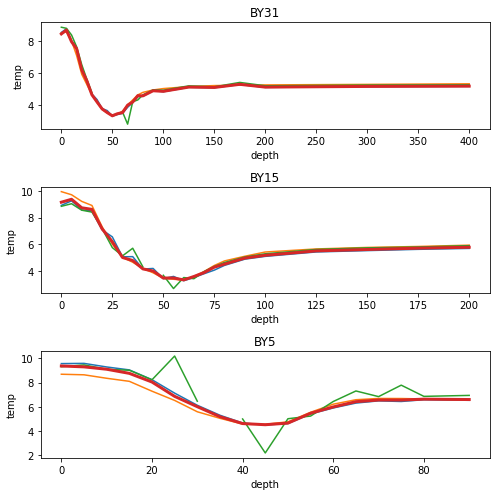

In [40]:
fig,ax = pl.subplots(3, figsize=(7,7))
ax[0].set_title('BY31')
ax[0].set_ylabel('temp')
test_data.preprocessed_datasets['ices']['by31'].groupby(level=[-1]).agg('mean').temp.plot(ax=ax[0])
test_data.preprocessed_datasets['iow']['by31'].groupby(level=[-1]).agg('mean').temp.plot(ax=ax[0])
test_data.preprocessed_datasets['shark']['by31'].groupby(level=[-1]).agg('mean').temp.plot(ax=ax[0])
test_data.combined_dataset['by31'].groupby(level=[-1]).agg('mean').temp.plot(ax=ax[0], lw=3)
ax[1].set_title('BY15')
ax[1].set_ylabel('temp')
test_data.preprocessed_datasets['ices']['by15'].groupby(level=[-1]).agg('mean').temp.plot(ax=ax[1])
test_data.preprocessed_datasets['iow']['by15'].groupby(level=[-1]).agg('mean').temp.plot(ax=ax[1])
test_data.preprocessed_datasets['shark']['by15'].groupby(level=[-1]).agg('mean').temp.plot(ax=ax[1])
test_data.combined_dataset['by15'].groupby(level=[-1]).agg('mean').temp.plot(ax=ax[1], lw=3)
ax[2].set_title('BY5')
ax[2].set_ylabel('temp')
test_data.preprocessed_datasets['ices']['by5'].groupby(level=[-1]).agg('mean').temp.plot(ax=ax[2])
test_data.preprocessed_datasets['iow']['by5'].groupby(level=[-1]).agg('mean').temp.plot(ax=ax[2])
test_data.preprocessed_datasets['shark']['by5'].groupby(level=[-1]).agg('mean').temp.plot(ax=ax[2])
test_data.combined_dataset['by5'].groupby(level=[-1]).agg('mean').temp.plot(ax=ax[2], lw=3)
pl.tight_layout()
pl.show()

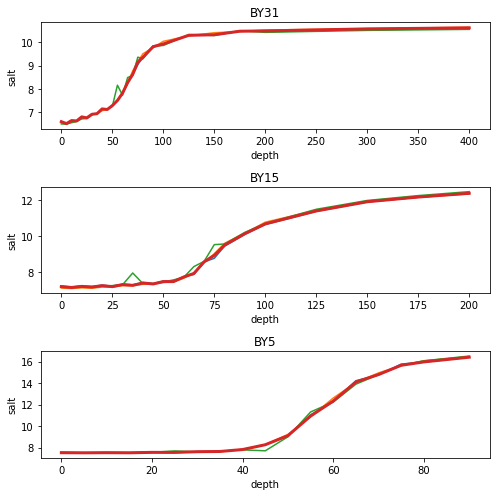

In [47]:
fig,ax = pl.subplots(3, figsize=(7,7))
ax[0].set_title('BY31')
ax[0].set_ylabel('salt')
test_data.preprocessed_datasets['ices']['by31'].groupby(level=[-1]).agg('mean').salt.plot(ax=ax[0])
test_data.preprocessed_datasets['iow']['by31'].groupby(level=[-1]).agg('mean').salt.plot(ax=ax[0])
test_data.preprocessed_datasets['shark']['by31'].groupby(level=[-1]).agg('mean').salt.plot(ax=ax[0])
test_data.combined_dataset['by31'].groupby(level=[-1]).agg('mean').salt.plot(ax=ax[0], lw=3)
ax[1].set_title('BY15')
ax[1].set_ylabel('salt')
test_data.preprocessed_datasets['ices']['by15'].groupby(level=[-1]).agg('mean').salt.plot(ax=ax[1])
test_data.preprocessed_datasets['iow']['by15'].groupby(level=[-1]).agg('mean').salt.plot(ax=ax[1])
test_data.preprocessed_datasets['shark']['by15'].groupby(level=[-1]).agg('mean').salt.plot(ax=ax[1])
test_data.combined_dataset['by15'].groupby(level=[-1]).agg('mean').salt.plot(ax=ax[1], lw=3)
ax[2].set_title('BY5')
ax[2].set_ylabel('salt')
test_data.preprocessed_datasets['ices']['by5'].groupby(level=[-1]).agg('mean').salt.plot(ax=ax[2])
test_data.preprocessed_datasets['iow']['by5'].groupby(level=[-1]).agg('mean').salt.plot(ax=ax[2])
test_data.preprocessed_datasets['shark']['by5'].groupby(level=[-1]).agg('mean').salt.plot(ax=ax[2])
test_data.combined_dataset['by5'].groupby(level=[-1]).agg('mean').salt.plot(ax=ax[2], lw=3)
pl.tight_layout()
pl.show()

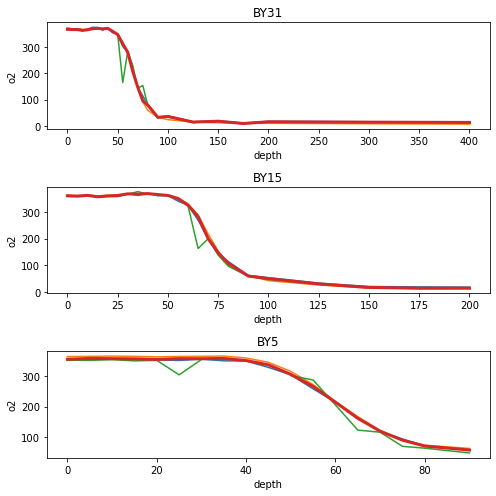

In [48]:
fig,ax = pl.subplots(3, figsize=(7,7))
ax[0].set_title('BY31')
ax[0].set_ylabel('o2')
test_data.preprocessed_datasets['ices']['by31'].groupby(level=[-1]).agg('mean').o2.plot(ax=ax[0])
test_data.preprocessed_datasets['iow']['by31'].groupby(level=[-1]).agg('mean').o2.plot(ax=ax[0])
test_data.preprocessed_datasets['shark']['by31'].groupby(level=[-1]).agg('mean').o2.plot(ax=ax[0])
test_data.combined_dataset['by31'].groupby(level=[-1]).agg('mean').o2.plot(ax=ax[0], lw=3)
ax[1].set_title('BY15')
ax[1].set_ylabel('o2')
test_data.preprocessed_datasets['ices']['by15'].groupby(level=[-1]).agg('mean').o2.plot(ax=ax[1])
test_data.preprocessed_datasets['iow']['by15'].groupby(level=[-1]).agg('mean').o2.plot(ax=ax[1])
test_data.preprocessed_datasets['shark']['by15'].groupby(level=[-1]).agg('mean').o2.plot(ax=ax[1])
test_data.combined_dataset['by15'].groupby(level=[-1]).agg('mean').o2.plot(ax=ax[1], lw=3)
ax[2].set_title('BY5')
ax[2].set_ylabel('o2')
test_data.preprocessed_datasets['ices']['by5'].groupby(level=[-1]).agg('mean').o2.plot(ax=ax[2])
test_data.preprocessed_datasets['iow']['by5'].groupby(level=[-1]).agg('mean').o2.plot(ax=ax[2])
test_data.preprocessed_datasets['shark']['by5'].groupby(level=[-1]).agg('mean').o2.plot(ax=ax[2])
test_data.combined_dataset['by5'].groupby(level=[-1]).agg('mean').o2.plot(ax=ax[2], lw=3)
pl.tight_layout()
pl.show()

In [211]:
#Testcase with validator data
#Define the object
test_data = obs_data_preprocessor(datasets=['validator', 'ices', 'iow', 'shark'], time_range=[dt.date(1948,1,1), dt.date(2018,12,31)])
#Construct variables
test_data.construct_variables(['temp', 'salt'], validator_path=['/silod4/naumov/obs_datasets_handler/validator_test/validator_temp',
                                                                '/silod4/naumov/obs_datasets_handler/validator_test/validator_salt'])
#Construct regions
test_data.construct_regions(['by5', 'by15', 'by31'], 
                            ['station', 'station', 'station'], 
                            [False, 
                             False, 
                             False],
                            [('circle', 10), ('circle', 10), ('circle', 10)],
                            [False, False, False])
#Execute the algorithm and get merged data
test_data.get_data()

Processing validator data...
Processing ICES data...
Processing IOW data...
Processing SHARK data...
Merging all data...


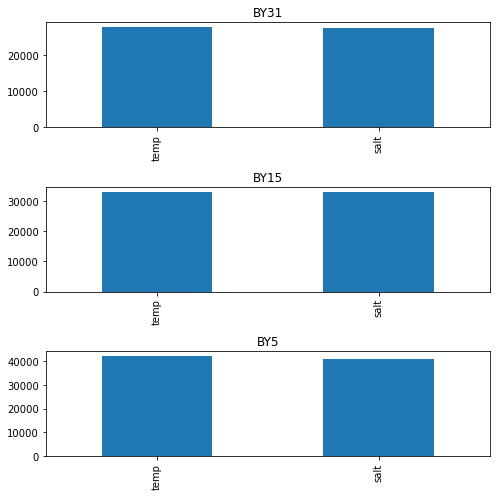

In [219]:
fig,ax = pl.subplots(3, figsize=(7,7))
ax[0].set_title('BY31')
test_data.combined_dataset['by31'].describe().loc['count',:].plot(kind='bar', ax=ax[0])
ax[1].set_title('BY15')
test_data.combined_dataset['by15'].describe().loc['count',:].plot(kind='bar', ax=ax[1])
ax[2].set_title('BY5')
test_data.combined_dataset['by5'].describe().loc['count',:].plot(kind='bar', ax=ax[2])
pl.tight_layout()
pl.show()

In [220]:
fig,ax = pl.subplots(3, figsize=(7,7))
ax[0].set_title('BY31')
test_data.combined_dataset['by31'].groupby(level=[-1]).agg('mean').temp.plot(ax=ax[0])
ax[1].set_title('BY15')
test_data.combined_dataset['by15'].groupby(level=[-1]).agg('mean').temp.plot(ax=ax[1])
ax[2].set_title('BY5')
test_data.combined_dataset['by5'].groupby(level=[-1]).agg('mean').temp.plot(ax=ax[2])
pl.tight_layout()
pl.show()

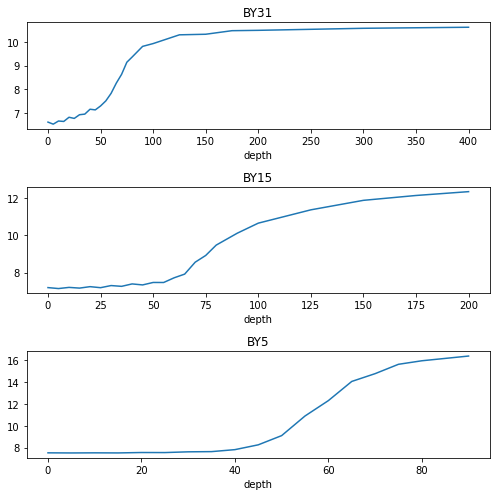

In [221]:
fig,ax = pl.subplots(3, figsize=(7,7))
ax[0].set_title('BY31')
test_data.combined_dataset['by31'].groupby(level=[-1]).agg('mean').salt.plot(ax=ax[0])
ax[1].set_title('BY15')
test_data.combined_dataset['by15'].groupby(level=[-1]).agg('mean').salt.plot(ax=ax[1])
ax[2].set_title('BY5')
test_data.combined_dataset['by5'].groupby(level=[-1]).agg('mean').salt.plot(ax=ax[2])
pl.tight_layout()
pl.show()